In [4]:
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# data_path = Path('/kaggle/input/hubmap-organ-segmentation')
data_path = Path('../data/processed')
files = [f.name for f in list(data_path.glob('*'))]
print(files)

['.gitkeep', 'sample_submission.csv', 'test.csv', 'test_images', 'train.csv', 'train_annotations', 'train_images']


# Install Libraries

In [5]:
# !pip install -U segmentation-models-pytorch -q

# View Data

## DataFrames

In [6]:
all_df = pd.read_csv(data_path / 'train.csv')
all_df.head()

id     organ data_source  img_height  img_width  pixel_size  \
0  10044  prostate         HPA        3000       3000         0.4   
1  10274  prostate         HPA        3000       3000         0.4   
2  10392    spleen         HPA        3000       3000         0.4   
3  10488      lung         HPA        3000       3000         0.4   
4  10610    spleen         HPA        3000       3000         0.4   

   tissue_thickness                                                rle   age  \
0                 4  1459676 77 1462675 82 1465674 87 1468673 92 14...  37.0   
1                 4  715707 2 718705 8 721703 11 724701 18 727692 3...  76.0   
2                 4  1228631 20 1231629 24 1234624 40 1237623 47 12...  82.0   
3                 4  3446519 15 3449517 17 3452514 20 3455510 24 34...  78.0   
4                 4  478925 68 481909 87 484893 105 487863 154 4908...  21.0   

      sex  
0    Male  
1    Male  
2    Male  
3    Male  
4  Female

In [7]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(all_df, test_size=0.20, random_state=42, stratify=all_df['organ'])

print(len(train_df), len(test_df))

280 71


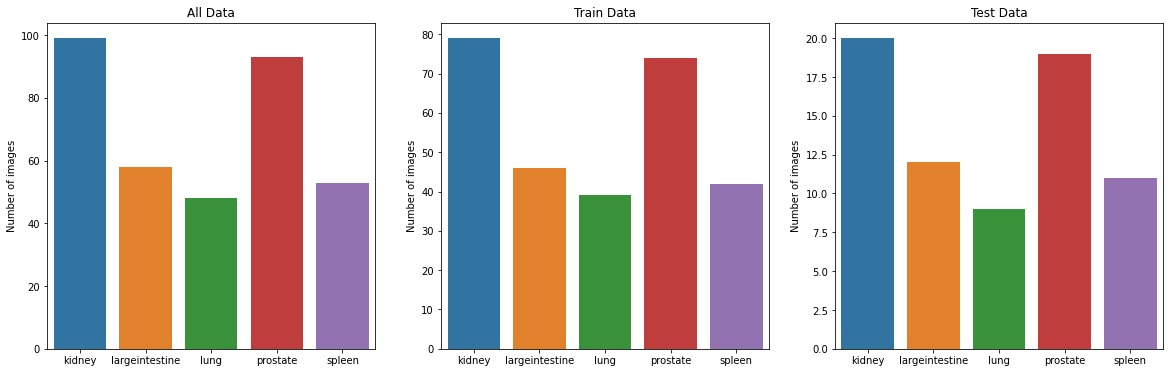

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for ax, df, title in zip(
    axes.ravel(),
    [all_df, train_df, test_df],
    ['All Data', 'Train Data', 'Test Data']
):
    
    ax.set_title(title)
    organ_cnt = Counter(df['organ'])
    keys = sorted(list(organ_cnt.keys()))
    values = [organ_cnt[k] for k in keys]
    sns.barplot(
        x = keys,
        y = values,
        ax=ax
    )
    ax.set_ylabel("Number of images")

## Images

100%|██████████| 351/351 [00:09<00:00, 37.91it/s]


Text(0, 0.5, 'Number of images')

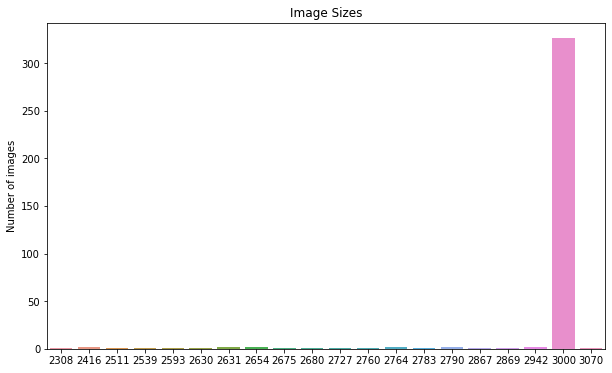

In [9]:
img_path = data_path / 'train_images'

img_shapes = Counter()
for im in tqdm(list(img_path.glob('*.tiff'))):
    img = cv2.imread(str(im))
    img_shapes[img.shape] += 1
    
    
plt.figure(figsize=(10,6))
plt.title("Image Sizes")
sizes = [s[0] for s in img_shapes.keys()]
values = [img_shapes[(s, s, 3)] for s in sizes]
sns.barplot(
    x=sizes,
    y=values,
)
plt.ylabel("Number of images")

In [10]:
def view_images(
    imgs, titles,
    rows, cols,
    masks = None, color=(255, 0, 0), br=0.5,
    figsize=(20, 20)
):
    assert(len(imgs) == len(titles) == rows*cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for idx, (ax, img, title) in enumerate(
        zip(axes.ravel(), imgs, titles)
    ):
        ax.set_title(title)
        draw_img = img.copy()
        if masks:
            mask = masks[idx].astype(bool)
            color_arr = np.zeros(draw_img.shape) + color
            draw_img[mask] = draw_img[mask]*(1 - br) + color_arr[mask]*br
            draw_img.astype(np.uint8)
        ax.imshow(draw_img)

    plt.show()

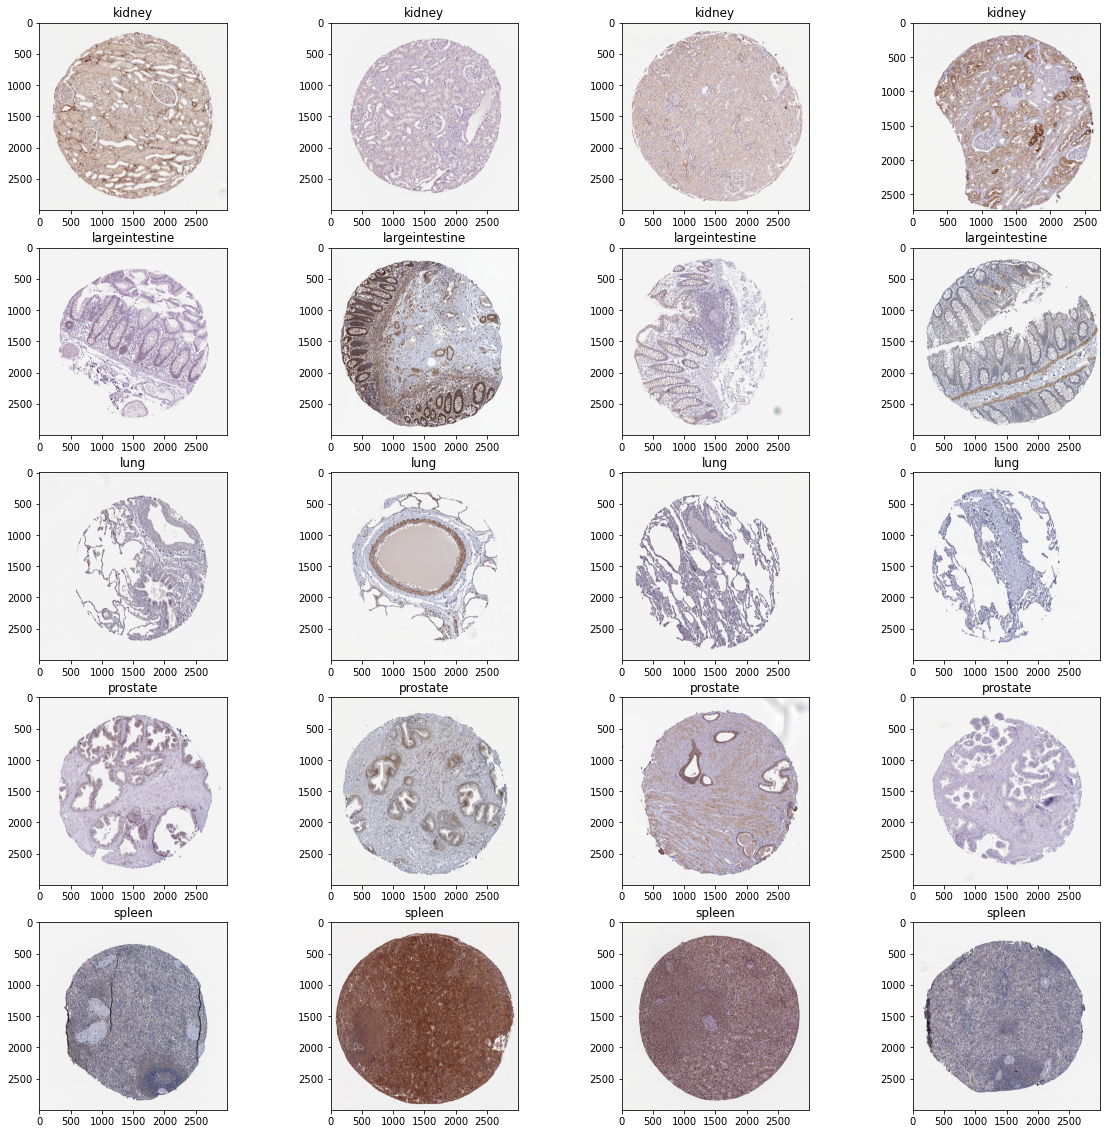

In [11]:
imgs, titles = [], []
labels = ['kidney', 'largeintestine', 'lung', 'prostate', 'spleen']
rows, cols = len(labels), 4

for r in range(rows):
    for c in range(cols):
        _df = all_df[all_df['organ'] == labels[r]].iloc[c]
        
        im = img_path / f"{_df.id}.tiff"
        img = cv2.imread(str(im))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        imgs.append(img)
        titles.append(_df.organ)
        
view_images(
    imgs, titles,
    rows, cols
)

In [12]:
def rle2mask(rle, size):
    rle = np.array(list(map(int, rle.split())))
    label = np.zeros((size*size), dtype=np.uint8)
    for start, end in zip(rle[::2], rle[1::2]):
        label[start:start+end] = 1
    return label.reshape(size, size).T

def mask2rle(mask):
    pixels = mask.T.flatten()   
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0]
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

str1 = all_df.iloc[0].rle
size = all_df.iloc[0].img_width
str2 = mask2rle(rle2mask(str1, size))
print(str1 == str2)

True


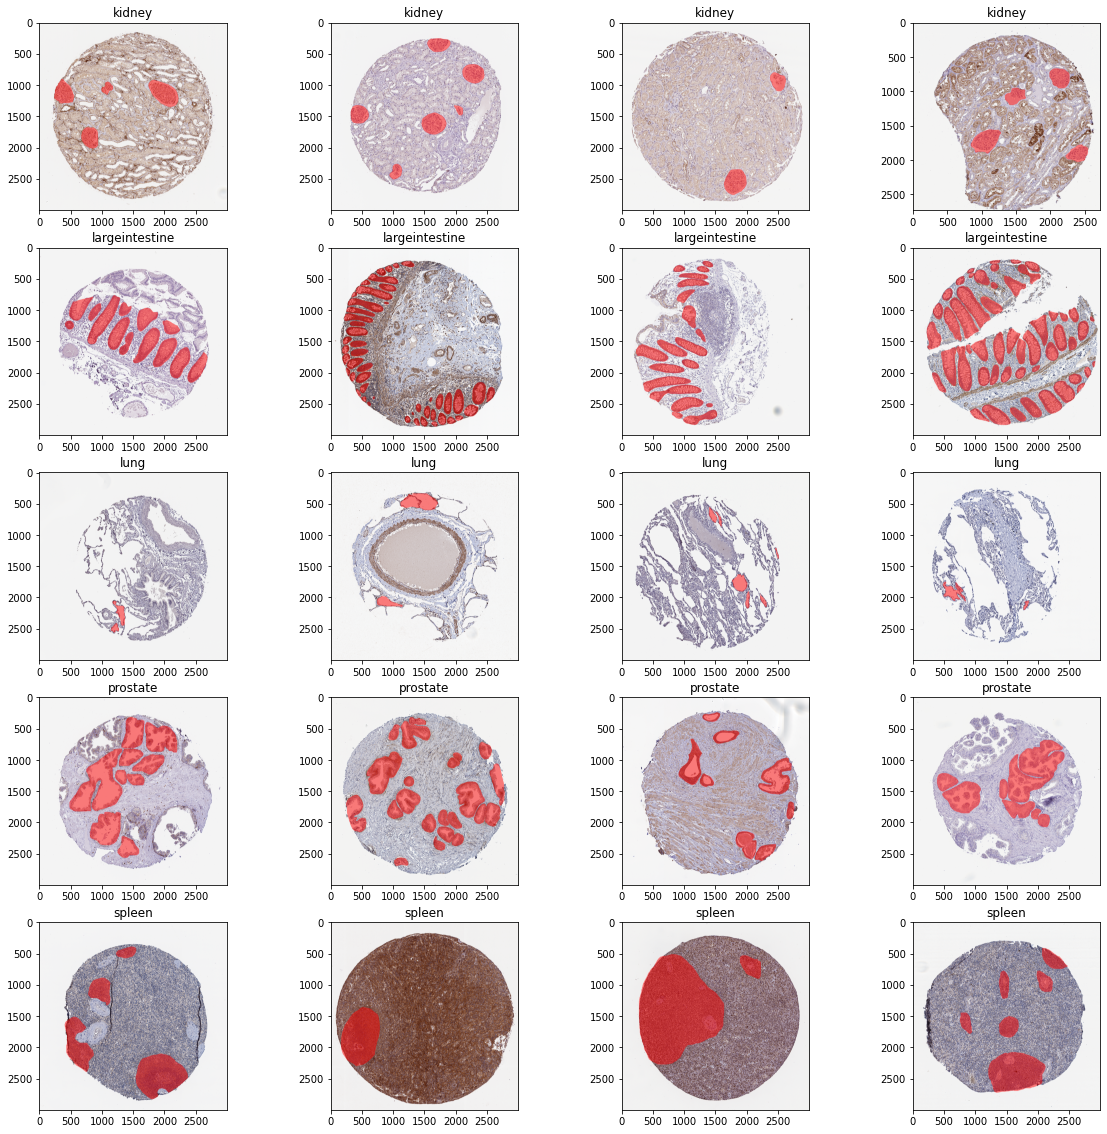

In [13]:
imgs, titles, masks = [], [], []
labels = ['kidney', 'largeintestine', 'lung', 'prostate', 'spleen']
rows, cols = len(labels), 4

for r in range(rows):
    for c in range(cols):
        _df = all_df[all_df['organ'] == labels[r]].iloc[c]
        
        im = img_path / f"{_df.id}.tiff"
        img = cv2.imread(str(im))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        mask = rle2mask(_df.rle, _df.img_width)
        
        imgs.append(img)
        titles.append(_df.organ)
        masks.append(mask)
        
view_images(
    imgs, titles,
    rows, cols,
    masks=masks
)

# Pytorch Dataset

In [14]:
from torch.utils.data import Dataset as BaseDataset
from torch.utils.data import DataLoader

class Dataset(BaseDataset):
    def __init__(
        self,
        df: pd.DataFrame, img_path: Path,
        transform: callable = None, return_class: bool = False
    ):
        self.df = df
        self.img_path = img_path
        self.transform = transform
        self.return_class = return_class

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        im = self.img_path / f"{self.df['id'].iloc[idx]}.tiff"
        img = cv2.imread(str(im))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        mask = rle2mask(rle=self.df['rle'].iloc[idx], size=self.df['img_width'].iloc[idx])
        mask = np.expand_dims(mask, axis=2)
        
        if self.transform:
            augment = self.transform(image=img, mask=mask)
            img, mask = augment['image'], augment['mask']
            
        if self.return_class:
            return img, mask, self.df['organ'].iloc[idx]
        return img, mask

/home/misha/.conda/envs/mlops-project/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
import albumentations as albu
from albumentations.pytorch import ToTensorV2

crop = 448
test_crop = 2016

# dataset for view images
view_dataset = Dataset(
    df = train_df,
    img_path = img_path,
    transform = albu.Compose([
        albu.PadIfNeeded(min_height=crop, min_width=crop),
        albu.CropNonEmptyMaskIfExists(height=crop, width=crop),
        albu.Flip(),
    ]),
    return_class = True
)
# train dataset
train_dataset = Dataset(
    df = train_df,
    img_path = img_path,
    transform = albu.Compose([
        albu.PadIfNeeded(min_height=crop, min_width=crop),
        albu.CropNonEmptyMaskIfExists(height=crop, width=crop),
        albu.Flip(),
        albu.Normalize(),
        ToTensorV2(transpose_mask=True)
    ])
)
# test dataset
test_dataset = Dataset(
    df = test_df,
    img_path = img_path,
    transform = albu.Compose([
        albu.PadIfNeeded(
            min_height=None,
            min_width=None,
            pad_height_divisor=32,
            pad_width_divisor=32,
        ),
        albu.Normalize(),
        ToTensorV2(transpose_mask=True)
    ])
)

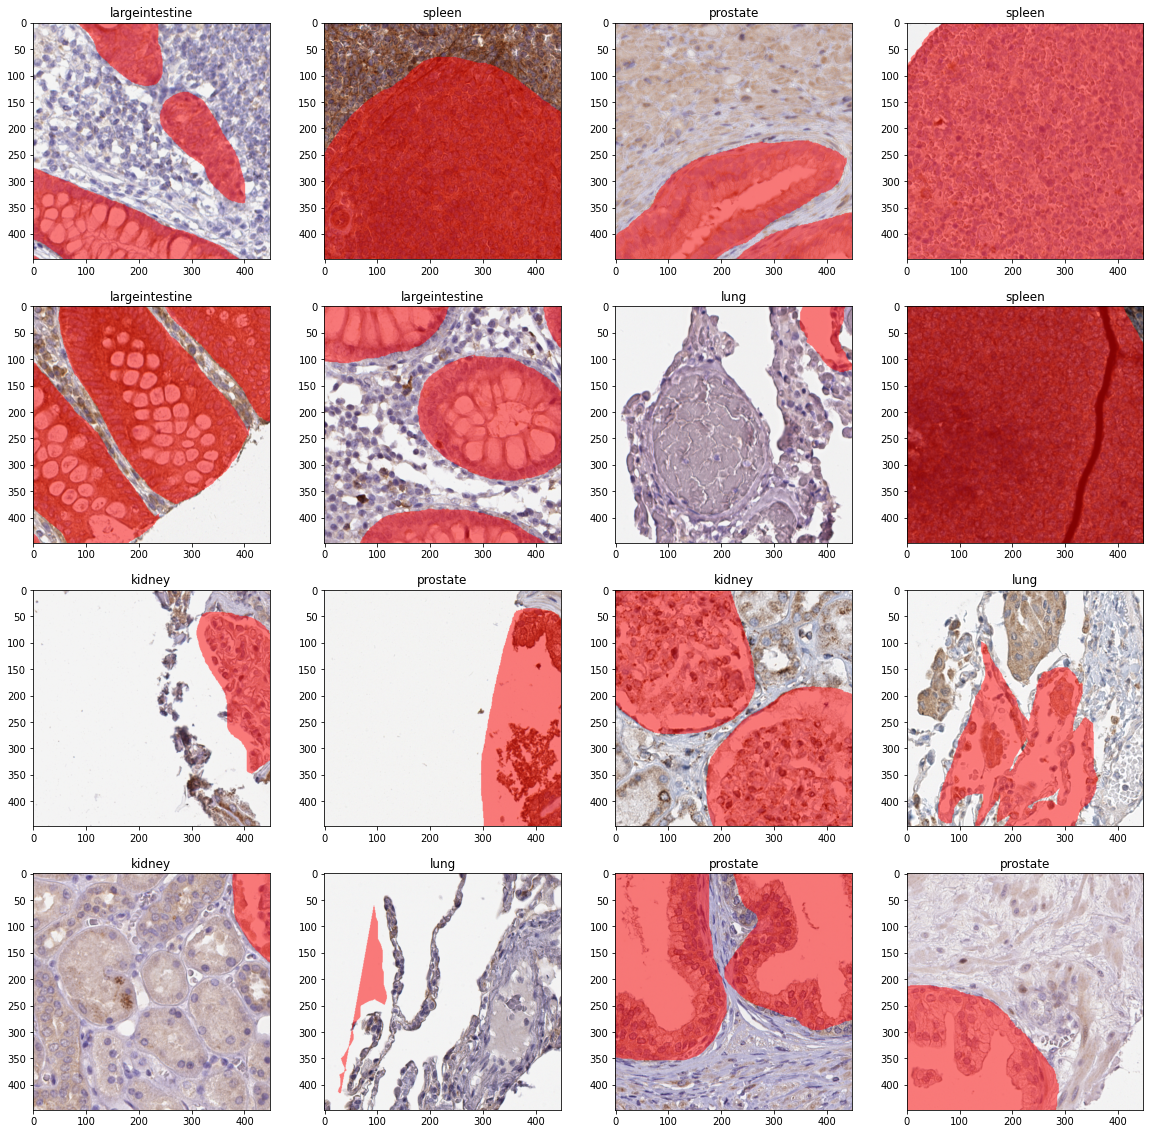

In [16]:
imgs, titles, masks = [], [], []
rows, cols = 4, 4

for r in range(rows):
    for c in range(cols):
        
        img, mask, label = view_dataset[r*rows + c]
        
        imgs.append(img)
        titles.append(label)
        masks.append(mask[:, :, 0])
        
view_images(
    imgs, titles,
    rows, cols,
    masks=masks
)

# Trainer

In [17]:
import torch
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from torchmetrics import MeanMetric, Dice
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

In [18]:
class Trainer:
    def __init__(
        self, 
        model,
        train_loader, test_loader,
        loss, metric,
        optimizer, sheduler
    ):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.loss = loss
        self.metric = metric
        self.optimizer = optimizer
        self.sheduler = sheduler
        
    def fit(self, epochs, device):
        
        best_dice = 0
        history = {
            'epochs': [],
            'lr': [],
            'train_loss': [],
            'train_dice': [],
            'test_loss': [],
            'test_dice': []
        }
        
        self.model.to(device)
        
        for epoch in range(epochs):
            
            history['epochs'].append(epoch)
            
            # Train epoch
            self.model.train()
            mean_loss = MeanMetric().to(device)
            mean_dice = MeanMetric().to(device)
            for x, y in tqdm(self.train_loader, desc=f"Train epoch {epoch}"):
                x, y = x.to(device), y.to(device)
                
                optimizer.zero_grad()
                pred = model(x)
                
                mean_dice.update(self.metric(pred, y.long()))
                
                l = self.loss(pred, y.long())
                mean_loss.update(l)
                
                l.backward()
                optimizer.step()
                
            history['train_loss'].append(mean_loss.compute().item())
            history['train_dice'].append(mean_dice.compute().item())
                
            # Test epoch
            self.model.eval()
            mean_loss = MeanMetric().to(device)
            mean_dice = MeanMetric().to(device)
            with torch.no_grad():
                for x, y in tqdm(self.test_loader, desc=f"Test epoch {epoch}"):
                    x, y = x.to(device), y.to(device)
                    pred = model(x)

                    mean_dice.update(self.metric(pred, y.long()))

                    l = self.loss(pred, y.long())
                    mean_loss.update(l)
            
            history['test_loss'].append(mean_loss.compute().item())
            history['test_dice'].append(mean_dice.compute().item())
            
            if best_dice < history['test_dice'][-1]:
                best_dice = history['test_dice'][-1]
                print(f"save best model with dice {best_dice}")
                torch.save(self.model, 'model_final.pth')
                
            history['lr'].append(self.sheduler.get_last_lr())
            self.sheduler.step()
            
        return history

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = smp.Unet(
    encoder_name = 'resnet18',
    encoder_weights = None,
    classes = 1,
    activation = None,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

loss = DiceLoss(mode='multilabel')
metric = Dice(
    average='samples',
    ignore_index=0,
).to(device)

lr = 3e-4
epochs = 100
optimizer = Adam(model.parameters(), lr=lr)
sheduler = CosineAnnealingLR(optimizer, T_max=epochs)

Using device: cuda


In [20]:
trainer = Trainer(
    model=model,
    train_loader=train_loader, test_loader=test_loader,
    loss=loss, metric=metric,
    optimizer=optimizer, sheduler=sheduler,
)

In [21]:
epochs = 10

In [22]:
history = trainer.fit(epochs, device)

Test epoch 0: 100%|██████████| 71/71 [00:27<00:00,  2.58it/s]


save best model with dice 0.15549537539482117


Test epoch 1: 100%|██████████| 71/71 [00:27<00:00,  2.61it/s]


save best model with dice 0.3024638593196869


Test epoch 2: 100%|██████████| 71/71 [00:27<00:00,  2.61it/s]


save best model with dice 0.35054805874824524


Test epoch 8: 100%|██████████| 71/71 [00:27<00:00,  2.55it/s]


save best model with dice 0.3531637191772461


Test epoch 9: 100%|██████████| 71/71 [00:27<00:00,  2.54it/s]

save best model with dice 0.35885459184646606


# Plot History

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[]

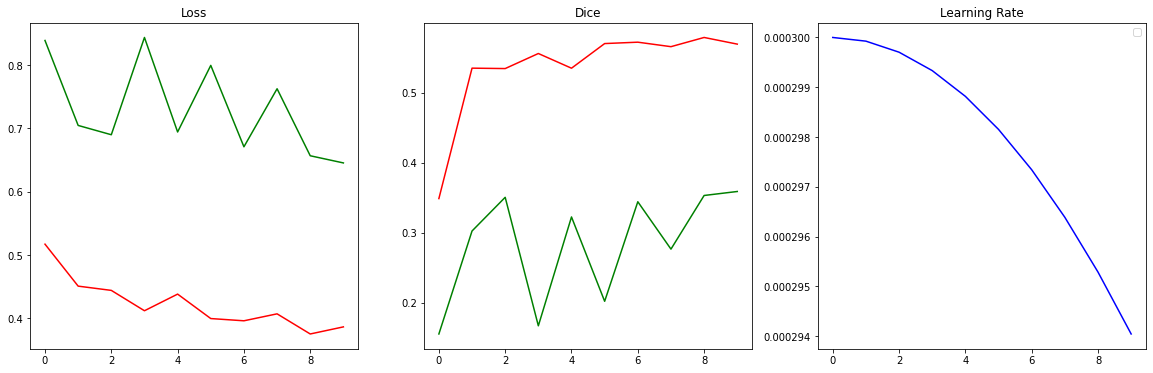

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# losses
axes[0].set_title('Loss')
axes[0].plot(history['epochs'], history['train_loss'], 'r', label='train')
axes[0].plot(history['epochs'], history['test_loss'], 'g', label='test')

# losses
axes[1].set_title('Dice')
axes[1].plot(history['epochs'], history['train_dice'], 'r', label='train')
axes[1].plot(history['epochs'], history['test_dice'], 'g', label='test')

# losses
axes[2].set_title('Learning Rate')
axes[2].plot(history['epochs'], history['lr'], 'b')

plt.legend()
plt.plot()
